In [30]:
import keras
import numpy as np
from moviepy.editor import VideoFileClip
import random
import os

import keras.backend as K
import matplotlib.pyplot as plt
import tensorflow as tf

In [74]:
data_dir = 'recurrent'
model_name = 'initialrecurrent16.10-0.00'
nonRec = 'initialnonrecurrent.10-0.00'
session = '180605_000'
windowSize = 15

In [3]:
clip = VideoFileClip(os.path.join(data_dir, 'sessions', session, 'runTop.mp4'))

In [33]:
def meanDistance(y_true, y_pred):
    in_shape = tf.shape(y_true)

    # Flatten height/width dims
    flat_true = tf.reshape(y_true, [in_shape[0], -1, in_shape[-1]])
    flat_pred = tf.reshape(y_pred, [in_shape[0], -1, in_shape[-1]])

    # Find peaks in linear indices
    idx_true = tf.argmax(flat_true, axis=1)
    idx_pred = tf.argmax(flat_pred, axis=1)

    # Convert linear indices to subscripts
    rows_true = tf.floor_div(tf.cast(idx_true,tf.int32), in_shape[2])
    cols_true = tf.floormod(tf.cast(idx_true,tf.int32), in_shape[2])
    
    rows_pred = tf.floor_div(tf.cast(idx_pred, tf.int32), in_shape[2])
    cols_pred = tf.floormod(tf.cast(idx_pred, tf.int32), in_shape[2])
    
    row_diff = tf.square(tf.subtract(tf.cast(rows_true, tf.float32), tf.cast(rows_pred, tf.float32)))
    col_diff = tf.square(tf.subtract(tf.cast(cols_true, tf.float32), tf.cast(cols_pred, tf.float32)))
    distances = tf.sqrt(tf.add(row_diff, col_diff))
    
    return tf.reduce_mean(distances)

In [75]:
net = keras.models.load_model(os.path.join('models', model_name+'.h5'), custom_objects={'meanDistance': meanDistance})
netnon = keras.models.load_model(os.path.join('models', nonRec+'.h5'), custom_objects={'meanDistance': meanDistance})

In [11]:
def getImg(frame):
        toRet = []
        for i in range(frame-windowSize+1, frame+1):
            img = clip.get_frame(i/clip.fps)
            x = np.asarray(img, dtype=K.floatx())[:,:,0]/255.
            x = x.reshape((x.shape[0], x.shape[1], 1))
            toRet.append(x)
        return toRet

In [81]:
test = getImg(100000)
test = np.asarray(test)

In [82]:
mean = np.reshape([0.257], [1,1,1,1])
std = np.reshape([0.288], [1,1,1,1])
toPred = np.array([test])
toPred-=mean
toPred/=std

In [83]:
preds = net.predict(toPred)

In [60]:
def findPt(predMap):
    in_shape = predMap.shape

    # Flatten height/width dims
    flat_true = np.reshape(predMap, [-1])

    # Find peaks in linear indices
    idx_true = np.argmax(flat_true)

    # Convert linear indices to subscripts
    rows_true = idx_true//in_shape[1]
    cols_true = idx_true%in_shape[1]
    
    return (cols_true, rows_true)

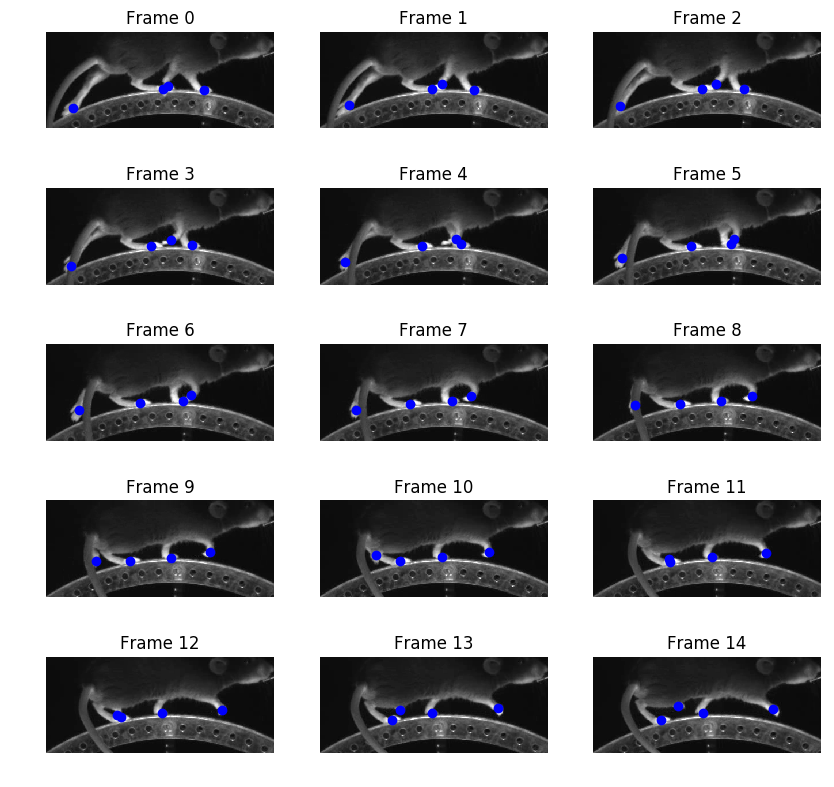

In [100]:
fig = plt.figure()
fig.set_size_inches(10, 10)
fig.set_dpi(100)
ax = fig.add_axes([0.,0.,1.,1.])
ax.axis('off')
for j in range(15):
    plt.subplot(5, 3, j+1)
    plt.title('Frame '+str(j))
    plt.imshow(np.repeat(test[j], 3, axis=2))
    for i in range(4):
        plt.plot(*findPt(preds[0,j,:,:,i]), 'bo')
    plt.axis('off')
plt.show()

In [85]:
preds2 = netnon.predict(toPred[0])


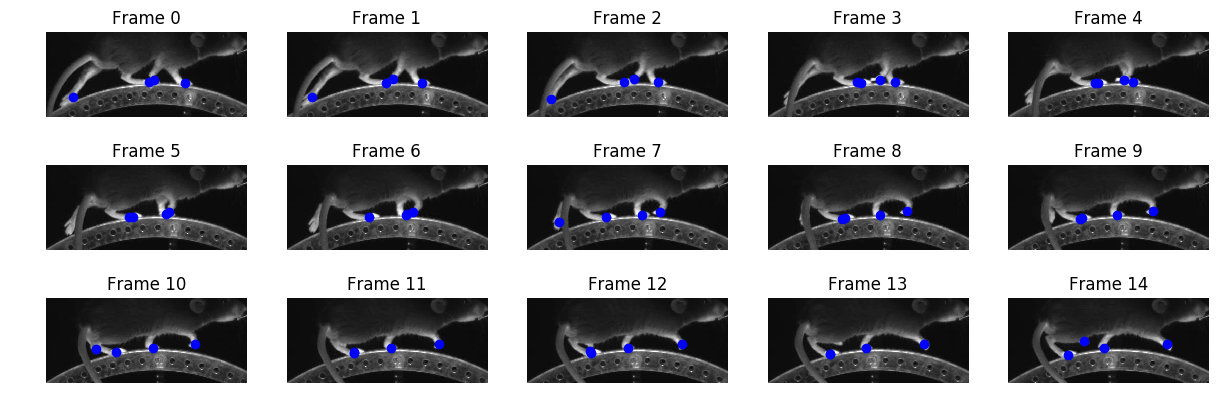

In [97]:
fig = plt.figure()
fig.set_size_inches(15, 5)
fig.set_dpi(100)
ax = fig.add_axes([0.,0.,1.,1.])
ax.axis('off')
for j in range(15):
    plt.subplot(3, 5, j+1)
    plt.title('Frame '+str(j))
    plt.imshow(np.repeat(test[j], 3, axis=2))
    for i in range(4):
        plt.plot(*findPt(preds2[j,:,:,i]), 'bo')
    plt.axis('off')
plt.show()